## Heart Failure Prediction Dataset

https://www.kaggle.com/fedesoriano/heart-failure-prediction

- Доделать файл с промежуточными результатами
- Подобрать гиперпараметры для svc и логистической регрессии
- выучить и применить бутстрэп
- попробовать автоматическую генерацию признаков
- делать target разбиение после split
- попробовать сделать таргет разбиение до удаления выбросов

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from IPython.display import Image

In [2]:
sns.set_theme()

bionic = ['#457DAF', '#BF2D2D', '#00A690', '#FFF373', '#FFC387', '#986960', '#97A5CD', '#586BA4', '#595358', '#E41B79', '#587B7F']
bionic_light = ['#5691C4', '#BF2D2D', '#00A690', '#FFF373', '#FFC387', '#986960', '#97A5CD', '#586BA4', '#595358', '#E41B79', '#587B7F']
bionic_r = bionic[::-1]
bionic_heatmap = ['#1E71B9', '#4B8DC7', '#78AAD5', '#A5C6E3', '#D2E3F1', '#FFFFFF', '#EBCCCC', '#D79999', '#C46666', '#B03333', '#9C0000']
bionic_gradient_narrow = ['#3982C1', '#88B4DA', '#BDD5EA', '#F2F6FA']
bionic_gradient = ['#1E71B9', '#357FC0', '#4B8DC7', '#629CCE', '#78AAD5', '#8FB8DC', '#A5C6E3', '#BCD4EA', '#D2E3F1', '#E9F1F8', '#FFFFFF']
bionic_gradient_wide = ['#00539C', '#0D5CA1', '#1964A6', '#266DAB', '#3375B0', '#407EB5', '#4C86BA', '#598FBF', '#6698C4', '#73A0C9', '#7FA9CD', '#8CB1D2', '#99BAD7', '#A6C3DC', '#B2CBE1', '#BFD4E6', '#CCDCEB', '#D9E5F0', '#E5EDF5', '#F2F6FA']
bionic_pairplot = ['#8DB4D7', '#BF2D2D', '#00A690', '#FFF373', '#FFC387', '#986960', '#97A5CD', '#586BA4', '#595358', '#E41B79', '#587B7F']
color = '#5691C4'

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", palette=bionic, rc=custom_params)

%matplotlib inline
pd.set_option("display.max_rows", 100)


#### Функции

In [3]:
def info (df):  
    
    var_list = df.columns
    tar_list = []
    con_feat_list = []
    dis_feat_list = []
    cat_feat_list = []
    bin_feat_list = []

    col = df.columns.to_list()
    col_var = df.describe().columns.to_list()
    
    for i in col[:-1]:
        if col_var.count(i) == 1:
            if df[i].value_counts().count() == 2:
                bin_feat_list.append(i)
                dis_feat_list.append(i)
            else:
                con_feat_list.append(i)
        if col_var.count(i) == 0:
            if df[i].value_counts().count() == 2:
                bin_feat_list.append(i)
                dis_feat_list.append(i)
            else:
                cat_feat_list.append(i)
                dis_feat_list.append(i)
    tar_list = col[-1:]

    print('')
    display(df.head())
    print('shape:', df.shape, '\n')
    print('Количественные переменные ({}):'.format((len(con_feat_list))))
    print(con_feat_list, '\n')
    print('Категориальные переменные ({}):'.format(len(cat_feat_list)))
    print(cat_feat_list, '\n')
    print('Бинарные переменные ({}):'.format(len(bin_feat_list)))
    print(bin_feat_list, '\n')
    print('Целевая переменная ({}):'.format(len(tar_list)))
    print(tar_list, '\n')
    print('Значения дискретных переменных:')
    for i in cat_feat_list:
        print('{}'.format(i), pd.unique(df[i]))
    for i in bin_feat_list:
        print('{}'.format(i), pd.unique(df[i]))
    print('')
    # display(df.describe().T)
    # print('')
    print(pd.concat([data_raw.dtypes.rename('Type').to_frame(), 
                     data_raw.isnull().sum().rename('NaN').to_frame()], 
                    axis=1), '\n')

    
def create_var_lists (df):  
    
    global var_list
    var_list = df.columns
    global tar_list
    tar_list = []
    global feat_list
    feat_list = df.columns[:-1]
    global con_feat_list
    con_feat_list = []
    global dis_feat_list
    dis_feat_list = []
    global cat_feat_list
    cat_feat_list = []
    global bin_feat_list
    bin_feat_list = []

    col = df.columns.to_list()
    col_var = df.describe().columns.to_list()
    
    for i in col[:-1]:
        if col_var.count(i) == 1:
            if df[i].value_counts().count() == 2:
                bin_feat_list.append(i)
                dis_feat_list.append(i)
            else:
                con_feat_list.append(i)
        if col_var.count(i) == 0:
            if df[i].value_counts().count() == 2:
                bin_feat_list.append(i)
                dis_feat_list.append(i)
            else:
                cat_feat_list.append(i)
                dis_feat_list.append(i)
    tar_list = col[-1:]
    feat_list = con_feat_list + cat_feat_list + bin_feat_list

    
def outliers (df, con_feat_list, scale):
    
    for i in con_feat_list:
        q75, q25 = np.percentile(df[i], [75 ,25]) 
        iqr = q75 - q25
        lower = q25 - scale*iqr
        upper = q75 + scale*iqr
        
        sns.histplot(data=df, x=i, multiple='stack', hue='hd')
        plt.show()
        print('Feature name: {}'.format(i))
        print('')
        print('25th Percentile: {} (Lower Fence: {})'.format(q25, lower))
        print('75th Percentile: {} (Upper Fence: {})'.format(q75, upper))
        print('Inter Quartile Range: {}'.format(iqr))
        print('Scale: {}'.format(scale))
        print('')
        print('Lower Outliers:', len(df[df[i] < lower]))
        print('Upper Outliers:', len(df[df[i] > upper]))
        print('')

        
def outliers_clean_full (df, con_feat_list, scale):

    df_clean = df.copy()
    
    for i in con_feat_list:
        q75, q25 = np.percentile(df[i], [75 ,25]) 
        iqr = q75 - q25
        lower = q25 - scale*iqr
        upper = q75 + scale*iqr

        df_clean = df_clean.drop(df_clean.loc[(df_clean[i] < lower) | (df_clean[i] > upper)].index)
        
        sns.histplot(data=df, x=i, multiple='stack', hue='hd')
        plt.show()
        print('Feature name: {}'.format(i))
        print('')
        print('25th Percentile: {} (Lower Fence: {})'.format(q25, lower))
        print('75th Percentile: {} (Upper Fence: {})'.format(q75, upper))
        print('Inter Quartile Range: {}'.format(iqr))
        print('Scale: {}'.format(scale))
        print('')
        print('Lower Outliers:', len(df[df[i] < lower]))
        print('Upper Outliers:', len(df[df[i] > upper]))
        print('')
        
    return df_clean


def outliers_clean_threshold (df, con_feat_list, scale, outliers_threshold):
    
    df_clean = df.copy()
    
    for i in con_feat_list:
        q75, q25 = np.percentile(df[i], [75 ,25]) 
        iqr = q75 - q25
        lower = q25 - scale*iqr
        upper = q75 + scale*iqr
        
        if len(df[df[i] < lower]) < outliers_threshold * len(df[i]):
            df_clean = df_clean.drop(df_clean.loc[(df_clean[i] < lower)].index)
        if len(df[df[i] > upper]) < outliers_threshold * len(df[i]):
            df_clean = df_clean.drop(df_clean.loc[(df_clean[i] > upper)].index)

    for i in con_feat_list:
        q75, q25 = np.percentile(df[i], [75 ,25]) 
        iqr = q75 - q25
        lower = q25 - scale*iqr
        upper = q75 + scale*iqr
        
        sns.histplot(data=df_clean, x=i, multiple='stack', hue='hd')
        plt.show()
        print('Feature name: {}'.format(i))
        print('')
        print('25th Percentile: {} (Lower Fence: {})'.format(q25, lower))
        print('75th Percentile: {} (Upper Fence: {})'.format(q75, upper))
        print('Inter Quartile Range: {}'.format(iqr))
        print('Scale: {}'.format(scale))
        print('')
        print('Lower Outliers:', len(df_clean[df_clean[i] < lower]))
        print('Upper Outliers:', len(df_clean[df_clean[i] > upper]))
        print('')
        
    return df_clean

## Содержание

Введение <br>
Исследовательский анализ (EDA) <br>

## 1. Введение
### Описание данных

 1   Age - возраст <br>
 2   Sex - пол <br>
&nbsp; &nbsp; &nbsp; &nbsp;   M - мужской <br>
&nbsp; &nbsp; &nbsp; &nbsp;   F - женский <br>
 3   ChestPainType - Тип боли в груди <br>
&nbsp; &nbsp; &nbsp; &nbsp;   TA: Типичная стенокардия <br>
&nbsp; &nbsp; &nbsp; &nbsp;   ATA: Нетипичная стенокардия <br>
&nbsp; &nbsp; &nbsp; &nbsp;   NAP: Не стенокардия <br>
&nbsp; &nbsp; &nbsp; &nbsp;  ASY: Отсутствие симптомов <br>
 4   RestingBP - артериальное давление в состоянии покоя   <br>
 5   Cholesterol - холестерин  <br>
 6   FastingBS - уровень сахара в крови натощак <br>
&nbsp; &nbsp; &nbsp; &nbsp;      1: >120 миллиграмм <br>
&nbsp; &nbsp; &nbsp; &nbsp;      0: <120 миллиграмм <br>
 7   RestingECG - электрокардиограмма в состоянии покоя <br>
&nbsp; &nbsp; &nbsp; &nbsp;    Normal: Нормальная <br>
&nbsp; &nbsp; &nbsp; &nbsp;    ST: аномалии типа ST-T (T wave inversions and/or ST elevation or depression of > 0.05 mV)  <br>
&nbsp; &nbsp; &nbsp; &nbsp;    LVH: показывающие вероятную или определенную гипертрофию левого желудочка по критериям Эстеса  <br>
 8   MaxHR - максимальная достигнутая частота пульса (от 60 до 202)  <br>
 9   ExerciseAngina - стенокардия, вызванная физической нагрузкой  <br>
&nbsp; &nbsp; &nbsp; &nbsp;    Y - присутствует <br>
&nbsp; &nbsp; &nbsp; &nbsp;    N - отсутствует <br>
 10   Oldpeak - числовое значение дисперсии, вызванной физическими нагрузками <br>
 11  ST_Slope - наклон сегмента ST при пиковом упражнении <br>
&nbsp; &nbsp; &nbsp; &nbsp;    Up: восходящий  <br>
&nbsp; &nbsp; &nbsp; &nbsp;    Flat: плоский  <br>
&nbsp; &nbsp; &nbsp; &nbsp;    Down: нисходящий <br>
 12  HeartDisease - сердечная недостаточность <br>
&nbsp; &nbsp; &nbsp; &nbsp;    1 - положительный исход  <br>
&nbsp; &nbsp; &nbsp; &nbsp;    0 - отрицательный исход <br>
      <br>
Набор сформирован из пяти разных источников:
- Cleveland: 303 observations
- Hungarian: 294 observations
- Switzerland: 123 observations
- Long Beach VA: 200 observations
- Stalog (Heart) Data Set: 270 observations

Всего: 1190 наблюдений <br>
Дубликаты: 272 наблюдения <br>
Итоговый датасет: 918 наблюдений

### Постановка задачи

Смоделировать наличие или отсутствие сердечной недостаточности у пациента по одинадцати параметрам. <br>
Сформировать .csv файл, который будет включать в себя ID пациента и спрогнозированный параметр HeartDisease

### Результаты



### Методы и подходы

## Исследовательский анализ (EDA)

1. Обзор данных
2. Очистка и преобразование данных <br>
&nbsp; Обзор данных <br>
&nbsp; Заполнение пропусков
3. Асимметрия данных (до и после очистки)
4. Сбалансированность значений целевой переменной
5. Непрерывные признаки <br>
6. Дискретные признаки <br>
7. Взаимодействие признаков <br>
&nbsp; Корреляции <br>
&nbsp; Возраст <br>
&nbsp; Мужчины и женщины <br>
&nbsp; Возраст + мужчины и женщины <br>


### 1. Обзор данных

Данные представлены единственным датасетом <br>
Датасет состоит из 11 признаков и 1 целевой переменной <br>
Признаки делятся на 5 непрерывных и 6 дискретных (из них 3 номинативных и 3 категориальные) <br>

Средний возраст пациентов - 53,5 года <br>
У 23% пациентов повышен уровень сахара <br>
У 55% пациентов случился сердечный приступ <br>

#### Загрузка датасета

In [4]:
data_raw = pd.read_csv('heart.csv')

#### Описание датасета

Значение уровеня холестерина не может равняться нулю. <br>
Элементов с нулевым значением холестерина 172, что составляет примерно 18.5 процентов от общего числа измерений. Соответственно, этими элементами нельзя пренебречь, просто исключив их из анализа. <br>

Для заполнения нулевых значений будет использоваться несколько подходов.

In [5]:
data_raw.columns = map(str.lower, data_raw.columns)
# data_raw = data_raw.reset_index().rename(columns={'index': 'id','heartdisease': 'hd'})
data_raw = data_raw.rename(columns={'heartdisease': 'hd'})

info(data_raw)
create_var_lists(data_raw)
data_raw.describe().T

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,hd
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


shape: (918, 12) 

Количественные переменные (5):
['age', 'restingbp', 'cholesterol', 'maxhr', 'oldpeak'] 

Категориальные переменные (3):
['chestpaintype', 'restingecg', 'st_slope'] 

Бинарные переменные (3):
['sex', 'fastingbs', 'exerciseangina'] 

Целевая переменная (1):
['hd'] 

Значения дискретных переменных:
chestpaintype ['ATA' 'NAP' 'ASY' 'TA']
restingecg ['Normal' 'ST' 'LVH']
st_slope ['Up' 'Flat' 'Down']
sex ['M' 'F']
fastingbs [0 1]
exerciseangina ['N' 'Y']

                   Type  NaN
age               int64    0
sex              object    0
chestpaintype    object    0
restingbp         int64    0
cholesterol       int64    0
fastingbs         int64    0
restingecg       object    0
maxhr             int64    0
exerciseangina   object    0
oldpeak         float64    0
st_slope         object    0
hd                int64    0 



,count,mean,std,min,25%,50%,75%,max
age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
restingbp,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
fastingbs,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
maxhr,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
hd,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


#### Непрерывные признаки

- **age**
- **restingbp** 
- **cholesterol** 
- **maxhr** 
- **oldpeak**

Наиболее характерно выражено взаимодействие между целевой переменной и такмии признаками, как maxhr, age. <br>
Это заметно на диаграммах рассеяния и KDE. <br>

Значение maxhr у пациентов с положительным диагнозом в целом ниже.<br>
Возраст пациентов с положительным диагнозом в целом выше.<br>

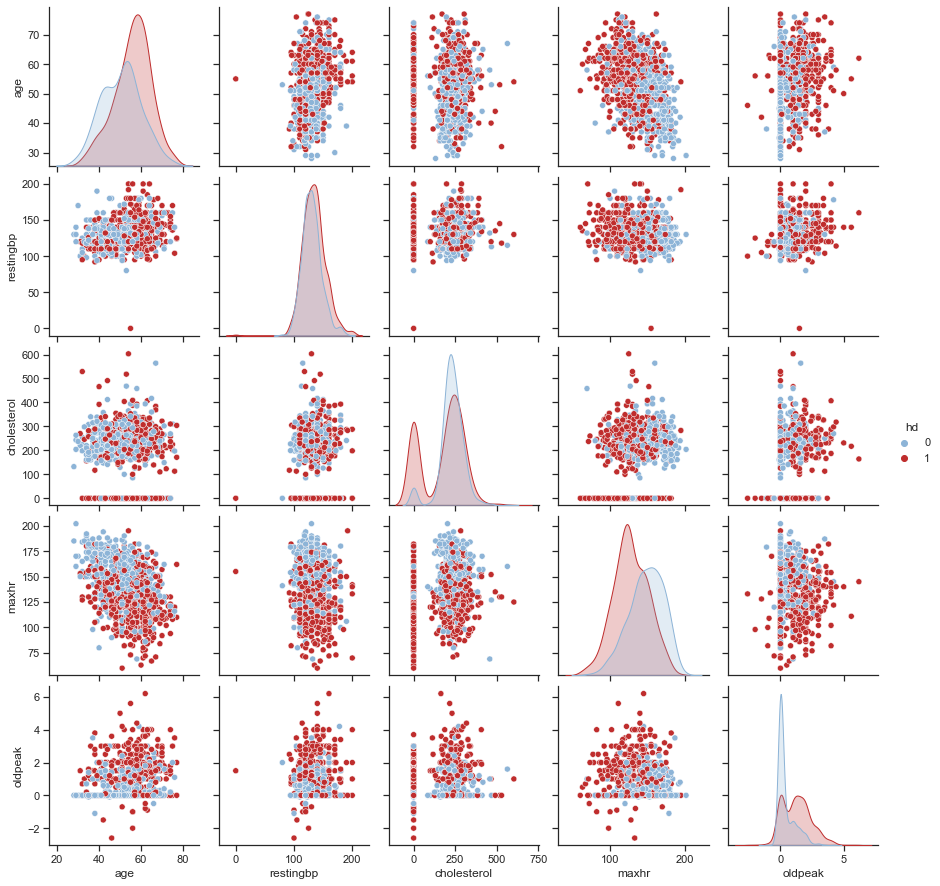

In [6]:
sns.pairplot(data_raw[con_feat_list + tar_list], hue='hd', height=2.5, palette=sns.color_palette(bionic_pairplot,2))
plt.show()

#### Дискретные признаки

- **sex** <br>
У мужчин горздо более высокие шансы на положительный исход. <br>
- **fastingbs** <br>
Если не равно 1, то скорее всего исход отрицательный <br>
- **exerciseangina** <br>
Если равна 1, то немного повышают вероятность отрицательного исхода. <br>
- **restingecg** <br>
Взаимосвязь отсутствует. <br>
- **st_slope** <br>
Если равен Flat, то видимо сильно взаимосвязана с положительным исходом <br>
- **chestpaintype** <br>
Отсутствие симтомов (ASY) в большинстве случаев означает положительнымй исход <br>
Если ATA, то скорее всего отрицательный исход <br>

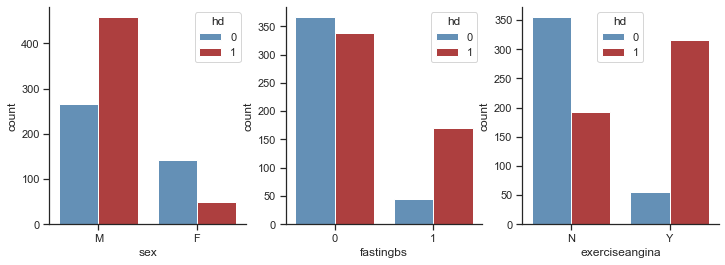

In [7]:
f, axes = plt.subplots(1,3, figsize=(12,4))

sns.countplot(data=data_raw[dis_feat_list + tar_list], x='sex', hue='hd', ax=axes[0], palette=bionic_light)
sns.countplot(data=data_raw[dis_feat_list + tar_list], x='fastingbs', hue='hd', ax=axes[1], palette=bionic_light)
sns.countplot(data=data_raw[dis_feat_list + tar_list], x='exerciseangina', hue='hd', ax=axes[2], palette=bionic_light)

plt.show()

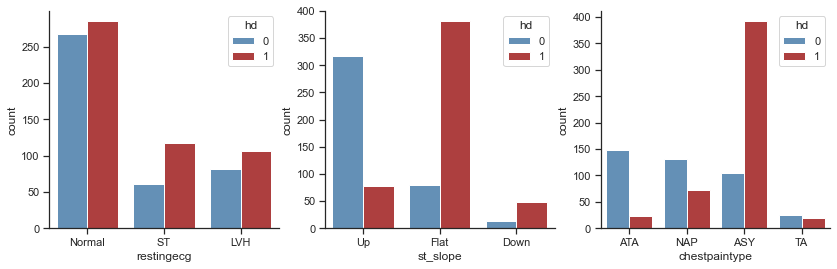

In [8]:
f, axes = plt.subplots(1, 3, figsize=(14,4))

sns.countplot(data=data_raw[dis_feat_list + tar_list], x='restingecg', hue='hd', ax=axes[0], palette=bionic_light)
sns.countplot(data=data_raw[dis_feat_list + tar_list], x='st_slope', hue='hd', ax=axes[1], palette=bionic_light)
sns.countplot(data=data_raw[dis_feat_list + tar_list], x='chestpaintype', hue='hd', ax=axes[2], palette=bionic_light)

plt.show()

### 2. Очистка и преобразование данных

#### 2.1. Выявление аномалий

**restingbp**: обнаружено два явных выброса <br>
**cholesterol** - обнаружено пропущенные значения



In [9]:
data = data_raw.copy()

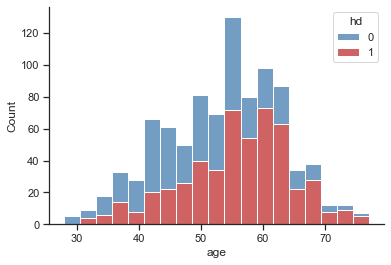

Feature name: age

25th Percentile: 47.0 (Lower Fence: 27.5)
75th Percentile: 60.0 (Upper Fence: 79.5)
Inter Quartile Range: 13.0
Scale: 1.5

Lower Outliers: 0
Upper Outliers: 0



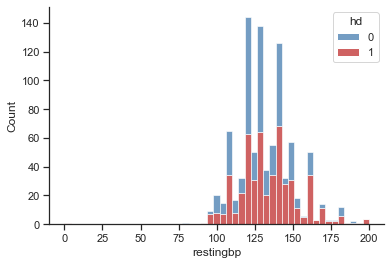

Feature name: restingbp

25th Percentile: 120.0 (Lower Fence: 90.0)
75th Percentile: 140.0 (Upper Fence: 170.0)
Inter Quartile Range: 20.0
Scale: 1.5

Lower Outliers: 2
Upper Outliers: 26



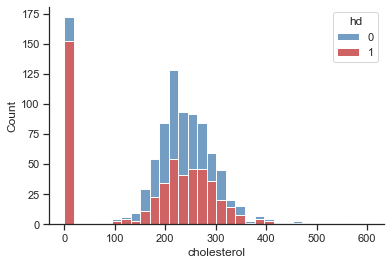

Feature name: cholesterol

25th Percentile: 173.25 (Lower Fence: 32.625)
75th Percentile: 267.0 (Upper Fence: 407.625)
Inter Quartile Range: 93.75
Scale: 1.5

Lower Outliers: 172
Upper Outliers: 11



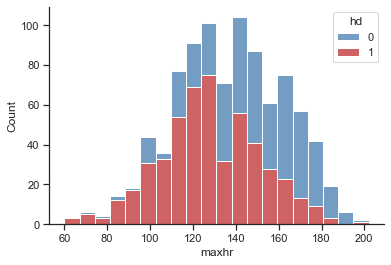

Feature name: maxhr

25th Percentile: 120.0 (Lower Fence: 66.0)
75th Percentile: 156.0 (Upper Fence: 210.0)
Inter Quartile Range: 36.0
Scale: 1.5

Lower Outliers: 2
Upper Outliers: 0



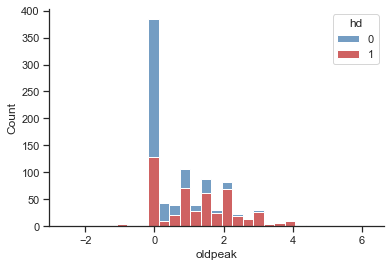

Feature name: oldpeak

25th Percentile: 0.0 (Lower Fence: -2.25)
75th Percentile: 1.5 (Upper Fence: 3.75)
Inter Quartile Range: 1.5
Scale: 1.5

Lower Outliers: 1
Upper Outliers: 15



In [10]:
outliers(data, con_feat_list, scale=1.5)

#### Заполнение нулевых значений cholesterol с помощью метода KNN-Imputation 

In [11]:
data.loc[data.cholesterol==0, 'cholesterol'].count()

172

In [12]:
data_imput_encoded = pd.get_dummies(data.drop('hd', axis=1), drop_first=1)
data_imput_encoded = pd.concat([data_imput_encoded, data['hd']], axis=1)
data_imput_encoded.columns = map(str.lower, data_imput_encoded.columns)

In [13]:
# заполняем NaN нулевые значения cholesterol и инииализируем KNN_imputed
# закидываем в KNN_imputed весь датасет data_encoded_oh и получаем на выходе преобразованные значения (метод .fit_transform)
# в формате np.ndarray.
# заполняем колонку cholesterol датасета data_encoded_oh значениями cholesterol, 
# полученными в результате преобразования KNN_imputed.fit_transform (делаем это ссылаясь на иднекс 2 в массиве np.ndarray, 
# так как у колонки cholesterol индекс 2)
data_imput_encoded.loc[data_imput_encoded.cholesterol==0, 'cholesterol'] = np.nan
KNN_imputed = KNNImputer(n_neighbors=5)
data['cholesterol'] = KNN_imputed.fit_transform(data_imput_encoded)[:, data_imput_encoded.columns.get_loc('cholesterol')]

,count,mean,std,min,25%,50%,75%,max
cholesterol_raw,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
cholesterol_cleaned,918.0,244.902832,54.680240,85.0,212.00,239.1,273.0,603.0


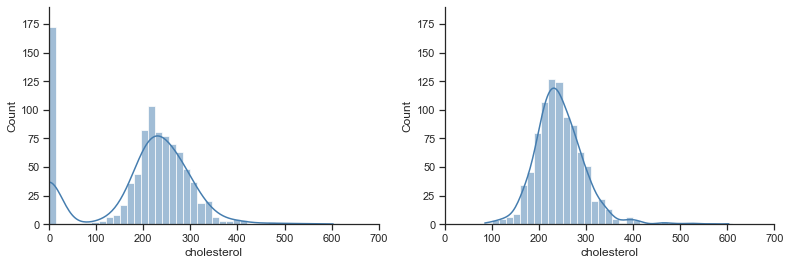

In [14]:
display(pd.concat([data_raw.cholesterol.describe().to_frame().T.rename(index={'cholesterol': 'cholesterol_raw'}),
           data.cholesterol.describe().to_frame().T.rename(index={'cholesterol': 'cholesterol_cleaned'})], axis=0))
print('')

f, ax = plt.subplots(1,2, figsize=(13,4))
custom_xlim = (0, 700)
custom_ylim = (0, 190)
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

sns.histplot(data=data_raw, x='cholesterol', kde=1, binwidth=15, ax=ax[0])
sns.histplot(data=data, x='cholesterol', kde=1, binwidth=15, ax=ax[1])

plt.show()

In [15]:
data

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,hd
0,40,M,ATA,140,289.0,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180.0,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283.0,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214.0,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195.0,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264.0,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193.0,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131.0,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236.0,0,LVH,174,N,0.0,Flat,1


#### Удаление выбросов

Удаляются значения, выходящие за пределы границы perc +/- 1.5*iqr в том случае, если число таких значений не превышает **outliers_threshold** от числа элементов 

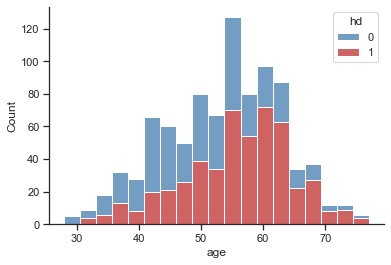

Feature name: age

25th Percentile: 47.0 (Lower Fence: 27.5)
75th Percentile: 60.0 (Upper Fence: 79.5)
Inter Quartile Range: 13.0
Scale: 1.5

Lower Outliers: 0
Upper Outliers: 0



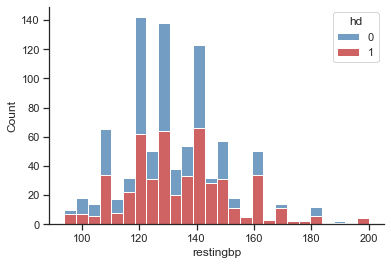

Feature name: restingbp

25th Percentile: 120.0 (Lower Fence: 90.0)
75th Percentile: 140.0 (Upper Fence: 170.0)
Inter Quartile Range: 20.0
Scale: 1.5

Lower Outliers: 0
Upper Outliers: 26



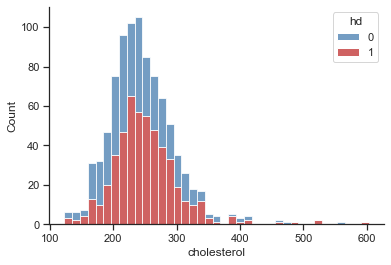

Feature name: cholesterol

25th Percentile: 212.0 (Lower Fence: 120.5)
75th Percentile: 273.0 (Upper Fence: 364.5)
Inter Quartile Range: 61.0
Scale: 1.5

Lower Outliers: 0
Upper Outliers: 22



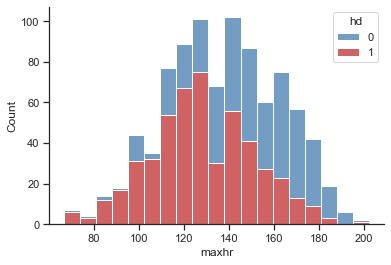

Feature name: maxhr

25th Percentile: 120.0 (Lower Fence: 66.0)
75th Percentile: 156.0 (Upper Fence: 210.0)
Inter Quartile Range: 36.0
Scale: 1.5

Lower Outliers: 0
Upper Outliers: 0



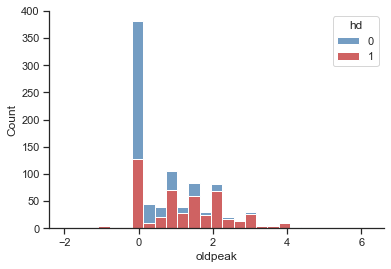

Feature name: oldpeak

25th Percentile: 0.0 (Lower Fence: -2.25)
75th Percentile: 1.5 (Upper Fence: 3.75)
Inter Quartile Range: 1.5
Scale: 1.5

Lower Outliers: 0
Upper Outliers: 15



In [16]:
data = outliers_clean_threshold(data, con_feat_list, scale=1.5, outliers_threshold=0.01).reset_index().drop('index', axis=1)

##### Датасет после удаления выбросов

In [17]:
data

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,hd
0,40,M,ATA,140,289.0,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180.0,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283.0,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214.0,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195.0,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
902,45,M,TA,110,264.0,0,Normal,132,N,1.2,Flat,1
903,68,M,ASY,144,193.0,1,Normal,141,N,3.4,Flat,1
904,57,M,ASY,130,131.0,0,Normal,115,Y,1.2,Flat,1
905,57,F,ATA,130,236.0,0,LVH,174,N,0.0,Flat,1


#### Перекодирование категориальных переменных

##### One Hot Encoding

In [18]:
data_encoded_onehot = data.copy()
data_encoded_onehot = pd.get_dummies(data.drop('hd', axis=1), drop_first=1)
data_encoded_onehot = pd.concat([data_encoded_onehot, data['hd']], axis=1)
data_encoded_onehot.columns = map(str.lower, data_encoded_onehot.columns)

##### Target Encoding

In [19]:
data_encoded_target = data.copy()
data_encoded_target = ce.TargetEncoder().fit_transform(data_encoded_target.drop('hd', axis=1), data_encoded_target.hd)
data_encoded_target = pd.concat([data_encoded_target, data['hd']], axis=1)
data_encoded_target.columns = map(str.lower, data_encoded_target.columns)

##### Датасет после перекодирования

In [20]:
data = data_encoded_target

In [21]:
data

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,hd
0,40,0.630252,0.139535,140,289.0,0,0.513812,172,0.346863,0.0,0.196429,0
1,49,0.259067,0.348259,160,180.0,0,0.513812,156,0.346863,1.0,0.825991,1
2,37,0.630252,0.139535,130,283.0,0,0.655367,98,0.346863,0.0,0.196429,0
3,48,0.259067,0.790984,138,214.0,0,0.513812,108,0.854795,1.5,0.825991,1
4,54,0.630252,0.348259,150,195.0,0,0.513812,122,0.346863,0.0,0.196429,0
...,...,...,...,...,...,...,...,...,...,...,...,...
902,45,0.630252,0.434783,110,264.0,0,0.513812,132,0.346863,1.2,0.825991,1
903,68,0.630252,0.790984,144,193.0,1,0.513812,141,0.346863,3.4,0.825991,1
904,57,0.630252,0.790984,130,131.0,0,0.513812,115,0.854795,1.2,0.825991,1
905,57,0.259067,0.139535,130,236.0,0,0.561497,174,0.346863,0.0,0.825991,1


#### Выявление мультиколлинеарности

Все переменные попадают в интервал VIF < 3, Tolerance > 0.2. <br>

In [22]:
def vif(exogs, data):

    vif_dict, tolerance_dict = {}, {}

    # разбиваем данные на экзогенные и эндогенные переменные
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = data[not_exog], data[exog]

        r_squared = LinearRegression().fit(X, y).score(X, y)

        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    # df_vif = df_vif.sort_values('VIF', ascending=0).reset_index().rename(columns={'index': 'Feature Name'})
    df_vif = df_vif.sort_values('VIF', ascending=0)
    
    return df_vif

In [23]:
vif(data.columns[:-1], data)

,VIF,Tolerance
st_slope,1.589674,0.629060
exerciseangina,1.562173,0.640134
maxhr,1.457348,0.686178
oldpeak,1.420639,0.703909
chestpaintype,1.410053,0.709193
age,1.342931,0.744640
restingbp,1.112692,0.898721
sex,1.091633,0.916058
fastingbs,1.085963,0.920842
restingecg,1.059522,0.943822


#### Корреляционная матрица

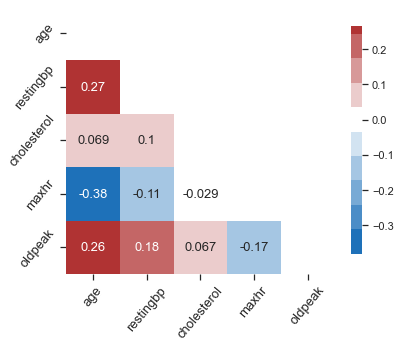

In [24]:
plt.subplots(figsize=(6,6))

# compute correlation matrix
con_features_corr_matrix = data[con_feat_list].corr()

# generate mask for upper triangle
mask = np.zeros_like(con_features_corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# generate heatmap masking the upper triangle and shrink the cbar
sns.heatmap(con_features_corr_matrix, mask=mask, center=0, square=True, annot=True, 
            cmap=bionic_heatmap, annot_kws={"size": 13}, cbar_kws={"shrink": 0.7})
plt.xticks(size=13)
plt.yticks(size=13)
plt.xticks(rotation=50)
plt.yticks(rotation=50)

plt.show()

#### Асимметрии непрерывных данных


In [25]:
skew = data[con_feat_list].skew(numeric_only=True)
data_skew = pd.DataFrame(skew, index=None, columns=['skewness'])

In [26]:
data_skew

,skewness
age,-0.205403
restingbp,0.649170
cholesterol,1.432530
maxhr,-0.113582
oldpeak,1.077752


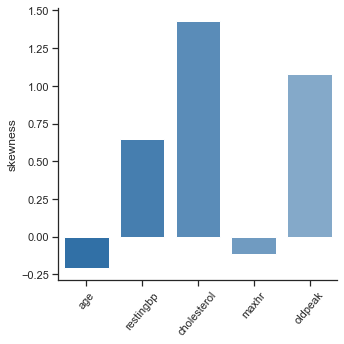

In [27]:
plt.figure(figsize=(5,5))
sns.barplot(x=data_skew.index, y='skewness', data=data_skew, palette=bionic_gradient)
plt.xticks(rotation=50)
plt.show()

#### Сбалансированность значений целевой переменной

Целевая переменная сбалансирована

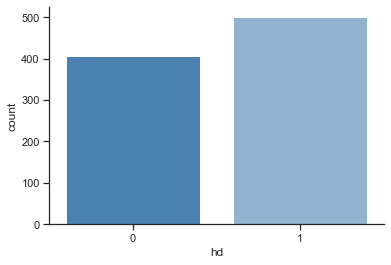

Сердечная недостаточность (положительные исходы): 500
Сердечная недостаточность (отрицательные исходы): 407 



In [28]:
sns.countplot(data=data, x='hd', palette=bionic_gradient_narrow)
plt.show()
print(f"Сердечная недостаточность (положительные исходы): {data.loc[data.hd == 1]['hd'].count()}")
print(f"Сердечная недостаточность (отрицательные исходы): {data.loc[data.hd == 0]['hd'].count()}", '\n')

#### Стандартизация непрерывных признаков

##### StandardScaler

In [29]:
# стандартизация параметров dis и создание датасета с номализованными параметрами
data_scaled_standard = StandardScaler().fit_transform(data[con_feat_list])
data_scaled_standard = pd.DataFrame(data_scaled_standard, index=data[con_feat_list].index, columns=data[con_feat_list].columns)

##### MinMaxScaler

In [30]:
# нормализация параметров dis и создание датасета с номализованными параметрами
data_scaled_minmax = MinMaxScaler(feature_range = (0,1)).fit_transform(data[con_feat_list])
data_scaled_minmax = pd.DataFrame(data_scaled_minmax, index=data[con_feat_list].index, columns=data[con_feat_list].columns)

##### Датасет после стандартизации

In [31]:
data[con_feat_list] = data_scaled_minmax[con_feat_list]

In [32]:
data

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,hd
0,0.244898,0.630252,0.139535,0.433962,0.345833,0,0.513812,0.777778,0.346863,0.243902,0.196429,0
1,0.428571,0.259067,0.348259,0.622642,0.118750,0,0.513812,0.659259,0.346863,0.365854,0.825991,1
2,0.183673,0.630252,0.139535,0.339623,0.333333,0,0.655367,0.229630,0.346863,0.243902,0.196429,0
3,0.408163,0.259067,0.790984,0.415094,0.189583,0,0.513812,0.303704,0.854795,0.426829,0.825991,1
4,0.530612,0.630252,0.348259,0.528302,0.150000,0,0.513812,0.407407,0.346863,0.243902,0.196429,0
...,...,...,...,...,...,...,...,...,...,...,...,...
902,0.346939,0.630252,0.434783,0.150943,0.293750,0,0.513812,0.481481,0.346863,0.390244,0.825991,1
903,0.816327,0.630252,0.790984,0.471698,0.145833,1,0.513812,0.548148,0.346863,0.658537,0.825991,1
904,0.591837,0.630252,0.790984,0.339623,0.016667,0,0.513812,0.355556,0.854795,0.390244,0.825991,1
905,0.591837,0.259067,0.139535,0.339623,0.235417,0,0.561497,0.792593,0.346863,0.243902,0.825991,1


### PCA

In [33]:
# from sklearn.decomposition import PCA

# pca = PCA()
# pca.fit(data.loc[:, data.columns != 'hd'])
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('PCA Number of Compoenents for Cumulative Variance')
# plt.show()

In [34]:
# data_pca = data.iloc[:,:-1]
# pca = PCA(n_components=8)
# data_pca = pca.fit_transform(data_pca)

In [35]:
# data_pca = pd.DataFrame(data=data_pca, columns= ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'])

In [36]:
# data_pca = pd.DataFrame(data=data_pca, columns= ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])

In [37]:
# data_pca = pd.DataFrame(data=data_pca, columns= ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

In [38]:
# data_pca = pd.DataFrame(data=data_pca, columns= ['1', '2', '3', '4', '5', '6', '7', '8'])

In [39]:
# data_pca['hd'] = data.hd

##### Датасет после PCA

In [40]:
# data_pca

#### Обучающий и тестовый наборы

In [41]:
X = data.drop('hd', axis=1)

In [42]:
y = data[tar_list].values.ravel()

In [43]:
# X = data_pca.drop('hd', axis=1)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53)

In [45]:
print(X_train.shape, X_test.shape)

(725, 11) (182, 11)


## Выбор модели

#### Функция оценки модели

In [46]:
def model_evaluation(clf):
    clf = clf # pass classifier to variable
    
    t_start = time.time() # record time
    clf = clf.fit(X, y) # classifier learning model
    t_end = time.time() # record time
    
    c_start = time.time() # record time
    accuracy = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    f1_score = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
    c_end = time.time() # record time
    
    # calculate mean of all 10 obs' accuracy and f1 as percent
    acc_mean = np.round(accuracy.mean() * 100, 2)
    f1_mean = np.round(f1_score.mean() * 100, 2)
    
    t_time = np.round((t_end - t_start) / 60, 3) # time for training
    c_time = np.round((c_end - c_start) / 60, 3) # time for evaluating scores
    
    clf = None # remove traces of classifier
    
    print(f'The accuracy score of this classifier is: {acc_mean}%.')
    print(f'The f1 score of this classifier is: {f1_mean}%.')
    print(f'This classifier took {t_time} minutes to train and {c_time} minutes to evaluate CV and metric scores.')

#### Benchmark:  MultinomialNB Classifier

In [47]:
# from sklearn.naive_bayes import MultinomialNB

# model_evaluation(MultinomialNB())

#### Выбор модели

- K-Nearest Neighbor (KNN)
- Random Forest (RF)
- Support Vector Machine (SVC)
- Stochastic Gradient Descent Classifier (SGDC)
- Extra Trees Classifier (ETC)
- Logistic Regression (LR)

#### Вывод

Лучший результат показала модель Random Forest Classifier. <br>

#### 1. K-Nearest Neighbors

In [48]:
from sklearn.neighbors import KNeighborsClassifier
model_evaluation(KNeighborsClassifier(n_jobs=-1))

The accuracy score of this classifier is: 82.02%.
The f1 score of this classifier is: 81.78%.
This classifier took 0.0 minutes to train and 0.062 minutes to evaluate CV and metric scores.


#### 2. Random Forest Classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier
model_evaluation(RandomForestClassifier(n_jobs=-1, random_state=53))

The accuracy score of this classifier is: 83.89%.
The f1 score of this classifier is: 83.6%.
This classifier took 0.004 minutes to train and 0.033 minutes to evaluate CV and metric scores.


#### 3. SVC

In [50]:
from sklearn.svm import SVC
model_evaluation(SVC())

The accuracy score of this classifier is: 83.67%.
The f1 score of this classifier is: 83.35%.
This classifier took 0.001 minutes to train and 0.004 minutes to evaluate CV and metric scores.


#### 4. Stochastic Gradient Descent Classifier 

In [51]:
from sklearn.linear_model import SGDClassifier
model_evaluation(SGDClassifier(n_jobs=-1, random_state=53))

The accuracy score of this classifier is: 81.03%.
The f1 score of this classifier is: 80.47%.
This classifier took 0.0 minutes to train and 0.002 minutes to evaluate CV and metric scores.


#### 5. Extra Trees Classifier

In [52]:
from sklearn.ensemble import ExtraTreesClassifier
model_evaluation(ExtraTreesClassifier(n_jobs=-1, random_state=53))

The accuracy score of this classifier is: 83.23%.
The f1 score of this classifier is: 82.98%.
This classifier took 0.004 minutes to train and 0.029 minutes to evaluate CV and metric scores.


#### 6. Logisitic Regression

In [53]:
from sklearn.linear_model import LogisticRegression
model_evaluation(LogisticRegression(n_jobs=-1, random_state=53, solver='saga', max_iter = 5000))

The accuracy score of this classifier is: 83.67%.
The f1 score of this classifier is: 83.39%.
This classifier took 0.0 minutes to train and 0.003 minutes to evaluate CV and metric scores.


# Подбор гиперпараметров

### **Hyper:** Random Forest Classifier

In [54]:
n_estimators = [50, 100, 300, 500, 1000]
min_samples_split = [2, 3, 5, 7, 9]
min_samples_leaf = [1, 2, 4, 6, 8]
max_features = ['auto','sqrt','log2',None]

hyper_grid = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

# scoring = 'accuracy'
scoring = 'f1'
# scoring = 'f1_macro'
# scoring = 'roc_auc'
# scoring = 'precision'
# scoring = 'recall'

rf = RandomForestClassifier(random_state=42)
random_cv = RandomizedSearchCV(estimator=rf, 
                               param_distributions=hyper_grid,
                               scoring=scoring,
                               cv=5, random_state=0)

random_cv.fit(X_train, y_train)

print("{} на тестовом наборе: {:.2f}".format(scoring.capitalize(),random_cv.score(X_test, y_test)))
print("Оптимальная модель:\n{}".format(random_cv.best_estimator_))

rf = None
random_cv = None

F1 на тестовом наборе: 0.93
Оптимальная модель:
RandomForestClassifier(min_samples_split=7, n_estimators=50, random_state=42)


### **Hyper:** Extra Trees Classifier

In [55]:
n_estimators = [50, 100, 300, 500, 1000]
min_samples_split = [2, 3, 5, 7, 9]
min_samples_leaf = [1, 2, 4, 6, 8]
max_features = ['auto','sqrt','log2',None]

hyperparameter_grid = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

# scoring = 'accuracy'
scoring = 'f1'
# scoring = 'f1_macro'
# scoring = 'roc_auc'
# scoring = 'precision'
# scoring = 'recall'

etc = ExtraTreesClassifier(random_state=42)
random_cv = RandomizedSearchCV(estimator=etc, 
                               param_distributions=hyper_grid,
                               scoring=scoring,
                               cv=5, random_state=0)

random_cv.fit(X_train, y_train)

print("{} на тестовом наборе: {:.2f}".format(scoring.capitalize(),random_cv.score(X_test, y_test)))
print("Оптимальная модель:\n{}".format(random_cv.best_estimator_))

etc = None
random_cv = None

F1 на тестовом наборе: 0.94
Оптимальная модель:
ExtraTreesClassifier(max_features='log2', min_samples_leaf=4,
                     min_samples_split=7, random_state=42)


### **Hyper:** SVM

In [56]:
C = [0.001, 0.01, 0.1, 1, 10, 100]
gamma = [0.001, 0.01, 0.1, 1, 10, 100]

hyper_grid = {'C': C,
              'gamma': gamma}

# scoring = 'accuracy'
scoring = 'f1'
# scoring = 'f1_macro'
# scoring = 'roc_auc'
# scoring = 'precision'
# scoring = 'recall'

svm = SVC(random_state=42)
random_cv = GridSearchCV(estimator=svm, 
                         param_grid=hyper_grid, 
                         scoring=scoring, cv=5)

random_cv.fit(X_train, y_train)

print("{} на тестовом наборе: {:.2f}".format(scoring.capitalize(),random_cv.score(X_test, y_test)))
print("Оптимальная модель:\n{}".format(random_cv.best_estimator_))

svm = None
random_cv = None

F1 на тестовом наборе: 0.93
Оптимальная модель:
SVC(C=100, gamma=0.1, random_state=42)


# Оптимальная модель

### **Final:** Random Forest Classifier

In [63]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score 
from sklearn.metrics import classification_report, average_precision_score

criterion = 'gini'
# criterion = 'entropy'

clf = RandomForestClassifier(min_samples_split=7, n_estimators=50, random_state=42, 
                             criterion = criterion)

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1]) 
av_per = average_precision_score(y_test, y_pred_prob[:, 1]) 

clf = None

print('Accuracy: {:.3f}'.format(accuracy))
print('F1-score: {:.3f}'.format(f1_score))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall), '\n')

print('ROC-AUC: {:.3f}'.format(roc_auc))
print('Average Precision: {:.3f}'.format(av_per))

Accuracy: 0.918
F1-score: 0.928
Precision: 0.907
Recall: 0.951 

ROC-AUC: 0.962
Average Precision: 0.972


### **Final:** Extra Trees Classifier

In [81]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score 
from sklearn.metrics import classification_report, average_precision_score

criterion = 'gini'
# criterion = 'entropy'

clf = ExtraTreesClassifier(max_features='log2', min_samples_leaf=4,
                     min_samples_split=7, random_state=42, 
                           criterion = criterion)

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1]) 
av_per = average_precision_score(y_test, y_pred_prob[:, 1])

feature_importances = pd.DataFrame(clf.feature_importances_, index=X_train.columns,
                                      columns=['ETC']).sort_values('ETC', ascending=0)

clf = None

print('Accuracy: {:.3f}'.format(accuracy))
print('F1-score: {:.3f}'.format(f1_score))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall), '\n')

print('ROC-AUC: {:.3f}'.format(roc_auc))
print('Average Precision: {:.3f}'.format(av_per), '\n') 

Accuracy: 0.929
F1-score: 0.938
Precision: 0.908
Recall: 0.971 

ROC-AUC: 0.975
Average Precision: 0.981 



### **Final:** SVM

In [68]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score 
from sklearn.metrics import classification_report, average_precision_score

clf = SVC(C=100, gamma=0.1, random_state=42)

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_df = clf.decision_function(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred_df) 
av_per = average_precision_score(y_test, y_pred_df)

clf = None

print('Accuracy: {:.3f}'.format(accuracy))
print('F1-score: {:.3f}'.format(f1_score))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall), '\n')

print('ROC-AUC: {:.3f}'.format(roc_auc))
print('Average Precision: {:.3f}'.format(av_per)) 

# print('')
# y_pred_lower_threshold = clf.decision_function(X_test) > -.5
# print(classification_report(y_test, y_pred_lower_threshold))

Accuracy: 0.912
F1-score: 0.925
Precision: 0.884
Recall: 0.971 

ROC-AUC: 0.958
Average Precision: 0.956


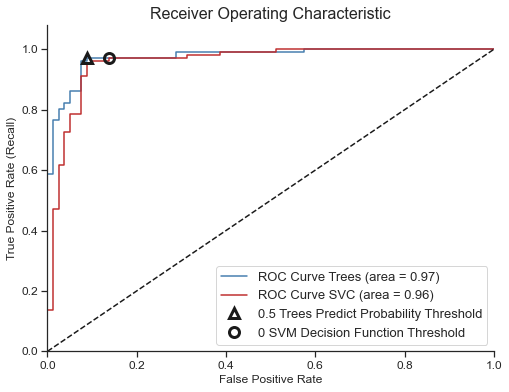

In [74]:
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred_df)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label='ROC Curve Trees (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_svm, tpr_svm, label='ROC Curve SVC (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.08])
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate (Recall)', fontsize = 12)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.xticks(size=12)
plt.yticks(size=12)

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5)) 
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], 
         '^', markersize=10, 
         label = '0.5 Trees Predict Probability Threshold', 
         fillstyle="none", c='k', mew=3)

close_zero_svm = np.argmin(np.abs(thresholds_svm)) 
plt.plot(fpr_svm[close_zero_svm], tpr_svm[close_zero_svm], 
         'o', markersize=10, 
         label ='0 SVM Decision Function Threshold', 
         fillstyle="none", c='k', mew=3)

plt.legend(loc="lower right", fontsize = 13)

# plt.savefig('roc_auc.png')

plt.show()

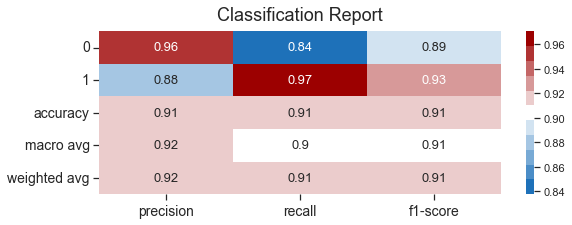

In [70]:
clf_report = classification_report(y_test,
                                   y_pred,
                                   target_names=['0', '1'],
                                   output_dict=True)

plt.subplots(figsize=(9,3))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, 
            cmap=bionic_heatmap, 
            annot_kws={"size": 13}, 
            cbar_kws={"shrink": 1}, 
            annot=True,
            yticklabels= ['0', '1', 'accuracy', 'macro avg', 'weighted avg'])

plt.xticks(size=14)
plt.yticks(size=14)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title('Classification Report', fontsize = 18, y=1.03)

# plt.savefig('classification_report.png')

plt.show()

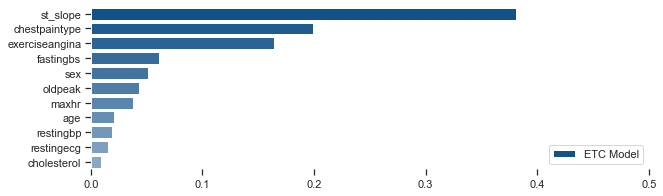

In [88]:
f, ax = plt.subplots(figsize=(10, 3))

sns.barplot(x='ETC', 
            y='index', 
            label='ETC Model', 
            palette=bionic_gradient_wide,
            data=feature_importances.sort_values('ETC', ascending=False).reset_index())

ax.legend(ncol=2, loc='lower right', frameon=True)
ax.set(xlim=(0, 0.5), ylabel="",
       xlabel="")
sns.despine(left=True, bottom=True)

### Настройка модели

#### Predict Probability Threshold

In [71]:
# Повышение порогового значения подразумевает, что модели требуется большая степень уверенности, чтобы принять решение
# в пользу положительного класса (или уменьшая степень уверенности, чтобы принять решение в пользу отрицательного класса).

In [72]:
def threshold_search_trees (y_pred_prob, y_test):
    
    array = np.arange(0.4, 0.5, 0.01)
    
    for i in array:
        y_pred_lower_threshold = np.where(y_pred_prob[:,1] >= i, 1,0)
        print('Threshold: {}'.format(i))
        print(classification_report(y_test, y_pred_lower_threshold))
# threshold_search(y_pred_proba, y_test)

In [540]:
def threshold_search_svm (y_pred_df, y_test):
    
    array = np.arange(-1, 0, 0.1)
    
    for i in array:
        y_pred_lower_threshold = np.where(y_pred_df >= i, 1,0)
        print('Threshold: {}'.format(i))
        print(classification_report(y_test, y_pred_lower_threshold))
# threshold_search_svm(y_pred_df, y_test)